# 시작하면서   
처음에는 피쳐자체가 적어서 좀적어서 어떻게 해줄까 고민을했습니다.  
분류문제이며 apply할것인가 말것인가를 결정하는 문지입니다. 

코드는  
1) 데이터를 정제하는 코드  
2) 훈련용 코드  

가있었으며 아래에 내용은 최대한 필요한 부분만 발췌해서 가지고와서 정리하였습니다. 

# 데이터와 문제.  
우선 테이블은  
1) train.csv    
2) job_tags.csv  
3) user_tags.csv   
4) tags.csv    
5) job_companies.csv    

파일로 나누어져있고 적절한 join,과 merge로 하나의 테이블로 만들어주는것이 첫번째였던거같습니다.  
데이터는 많은 정보는 없는거같고 user와 company간에 얼마나 유사한가가 약간 관련성이고    
일단 applied는 user의몫이니 user가 얼마나 company에 관심이 있는지 알아내는것이 관건이라고 생각했습니다.    
일단은 테니블들을 조인해줘서 그후에 분석을 진행했습니다.  

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from collections import Counter
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [3]:
path = '/mnt/3CE35B99003D727B/input/jabfair2019/recommender_system/'

# Table Join  
테니블 join들을 통해서 1차적으로 정리를 해주었습니다.  
우선적으로 어플라이언스의  keyword와 회사의 keyword를 구분해주도록 조인했으며  
이 값들을 가지고 회사와 어플라이언스의 관심도를 비교했습니다.  

In [ ]:
jobdf = pd.merge(train, job_tags, on="jobID", how="left")
jobdf = pd.merge(jobdf,job_companies, on='jobID', how='left')
jobdf = pd.merge(jobdf, tags , on='tagID', how='left')
jobdf = jobdf.drop(['tagID','applied'], axis=1)
jobdf=jobdf.rename(columns = {'keyword':'job_keyword'})

userdf = pd.merge(train, user_tags, on='userID', how='left')
userdf = pd.merge(userdf, tags , on='tagID', how='left')
userdf = userdf.drop(['tagID'], axis=1)
userdf=userdf.rename(columns = {'keyword':'user_keyword'})

df = pd.merge(jobdf,userdf, on=['userID','jobID'], how='left')
df = df[['userID', 'jobID','companyID' ,'companySize', 'job_keyword', 'user_keyword','applied']]

df[df.applied ==1]


df.companySize.fillna('0', inplace=True)

df.loc[df.companySize == "1-10",'companySize'] = 1
df.loc[df.companySize == "11-50",'companySize'] = 2
df.loc[df.companySize == "51-100",'companySize'] = 3
df.loc[df.companySize == "101-200",'companySize'] = 4
df.loc[df.companySize == "201-500",'companySize'] = 5
df.loc[df.companySize == "501-1000",'companySize'] = 6
df.loc[df.companySize == "1000 이상",'companySize'] = 7

# Table 첫 feature 생성 
테이블을 조인했지만 테이블 자체에 많은 데이터는 존재 하지 않아서 일단 companySize,job_keyword,user_keyword 에대한 
mean,var,sum값을 구했습니다. 일단은 이부분이 메인으로 분석하는 중요한 feature가되었습니다.   

In [ ]:
companySize_df = df.groupby(['userID','jobID','companyID'])['companySize'].agg({'mean','var','sum'}).reset_index()
job_keyword_df = df.groupby(['userID','jobID','companyID'])['job_keyword'].agg({'mean','var','sum'}).reset_index()
user_keyword_df = df.groupby(['userID','jobID','companyID'])['user_keyword'].agg({'mean','var','sum'}).reset_index()
applied_df = df.groupby(['userID','jobID','companyID'])['applied'].agg({'mean'}).reset_index()

df2 = pd.merge(companySize_df, job_keyword_df , how='left', on=['userID','jobID','companyID'])

df2.columns = ['userID','jobID','companyID'\
           ,'sum_companySize','mean_companySize','var_companySize'\
           ,'sum_job','mean_job','var_job'\
              ]

df3.columns = ['userID','jobID','companyID'\
           ,'sum_companySize','mean_companySize','var_companySize'\
           ,'sum_job','mean_job','var_job'\
            ,'sum_userkeyword','mean_uerkeyword','var_userkeyword'
              ]

In [5]:
job_companies = pd.read_csv(path + "job_companies.csv")
job_tags = pd.read_csv(path + "job_tags.csv")
sample_output_job= pd.read_csv(path + "sample_output_job.csv")
tags= pd.read_csv(path + "tags.csv")
test= pd.read_csv(path + "test_job.csv")
train= pd.read_csv(path + "train.csv")
user_tags= pd.read_csv(path + "user_tags.csv")  

그리고 처음에는 keyword에대한 값을 랜덤으로 숫자로 표현해줬지만  좀더 비슷한 word끼리 묶어주면 더 의미가 있지 않을까하고   
임의로 묶어 주었습니다.  나중에는 word similarity로 구해주고싶었지만 기존에 pretained에는 machine learning같은 keyword는 존재하지 않아서 마지막에 word2vec처럼 만들어줄려고했으나 시간관계로 일단 임의로 다음과 같이 나누어주었습니다.  

아래에 나누어 준것들은 시간관계상 제가 임으로 game, unknown, machine learning, ruby, web, embedded, java , database, mobile, stuff으로 나누어 주었으며 정확한 값들은 아닙니다.   

기존에 있던 word similarity로 구해줘보려고했으나 없는 단어도 많고 정제가 너무 오래 걸려서 일단은 보류했습니다. 

In [6]:
'''
임의의 keyword groups

'''
game = [
              'Unreal Engine','AWS ElastiCache','Unity', 'VR'
    
    
] 

unkown = [
                    'Google Cloud Natural Language','Google Dialogflow','InVision','Sketch','Expo',
                     'RxKotlin','Dependency Lookup','Packer','Entity Framework','Google Cloud SDK',
                     'Google Cloud Platform','Google Firebase Crashlytics','CocoaPods','IOCP','Heroku',
                     'CAD','Qt','AWS Security Hub','WordPress','ASP',
                     'Apache ZooKeeper','Canvas','AWS IAM','WPF','Ionic',
                     'Axios'
                      ,'Cocoa','Cocos2d','MVP','Bamboo','Capistrano','RabbitMQ','UML','Microservice Architecture'
                      ,'AWS ECS','NCP(Naver Cloud Platform)','Vuex','OpenLayers','Naver Cloud Platform','gRPC'
                      ,'Electron','Microsoft IIS'
                      ,'Mocha','Jest','Memcached','Fluentd','Kibana','AWS CloudWatch'
                    ,'AWS Backup','Redux-Observable',
                    'Laravel','Retrofit','OpenGL','WebGL','Ansible',
                     'styled-components','AWS RDS','AWS EKS','Terraform','AWS S3',
                     'AWS Lambda','ES6','PostgreSQL','Firebase','Realm','OpenStack','GCP(Google Cloud Platform)'
                     ,'CI/CD','Google Cloud Firestore','Cuckoo Sandbox','Chrome Extension'
    
]

machine_learning  = [
                     'Python','Tensorflow','PyTorch','Scala','NLP',
                     'Apache','Kotlin','Azure Text Analytics','CUDA','Pandas',
                     'OpenCV','Blockchain','Ethereum','Keras',
                     'Scikit-Learn','gensim','Big Data','Data Analysys'
                     ,'Apache Hadoop','Azure','Elastic Stack','AWS ElasticBeanstalk','R','Machine Vision',
                      'Machine Learning','Apache Spark'
                      ,'Deep Learning','Apache Kafka','CodeIgniter','Sass(SCSS)','Microsoft Azure','Elasticsearch'
                      ,'Data mining','Apache Hive','TF-IDF','Tkinter','Azure Dedicated HSM', 'Yarn','YOLO'
                      ,'공공데이터','Numpy','Apache Pig'
]

ruby = [             'Ruby on Rails','Ruby','Angular'
                    
       
       ]

web = [
                     'AWS DynamoDB','Swift','JavaScript','React Native','ReactJS',
                     'TypeScript','Vue.js','Webpack','Amazon Web Services(AWS)','Kubernetes',
                     'PHP','Node.js','REST API','Go','Redux-Saga',
                     'Redux.js','Babel','GraphQL','Jenkins','Django',
                      'Git','AWS EC2','CSS','HTML','Docker',
                      'Kotlin','jQuery','RxJS','AngularJS','XML',
                     'Jekyll','Selenium','Consul','Nexus','Backbone.js',
                     'PostCSS','GatsbyJS','Google API','Apache HTTP Server','Grunt',
                     'ThreeJS','Responsive Web','D3.js','OkHttp','BitBucket',
                     'PKI(Public key infrastructure)','NestJS','JIRA','Less.js','Puppeteer',
                     'AWS Simple Queue Service(AWS SQS)','Gradle','GitLab','DRF(Django REST framework)','AWS X-Ray'
                     ,'Rust','Bootstrap','web3.js','Oracle','ExpressJS','ActionScript','Nginx','Flask'
                      ,'RxSwift','HTML5','Ajax','TCP/IP','Next.js','i18n', 'CSS3','SockJS','Facebook API', 'KakaoPay API'
                    ,'Toss API','Phaser', 'T map API','Google Maps API'

]
embedded = [
    
                     'C#','C','Embedded System','C++','Windows Embedded',
                     'Windows kernel','Unix','Azure Linux Virtual Machines','Socket.IO','Shell Script',
                     'DSP(Digital Signal Processing)','Raspberry Pi','Arduino','Red Hat Ceph Storage','Ubuntu',
                     'Datadog','.NET','ASP.NET','Shell','Linux kernel','GitHub','Linux','Objective-C','Perl','centOS'
                     ,'Verilog','소켓'
    
]
java = [
                     'Java','Spring','MVVM(Model-View-ViewModel)','MyBatis','Spring Data JPA',
                     'JUnit','Spring Batch','Hibernate','Apache Tomcat','Apache Subversion(SVN)',
                     'Spring Cloud','JSP','Logstash','MVC','RxJava',
                     'gulp','OOP','Spring Boot','Nuxt.js','JPA(Java Persistent API)','Vue CLI'
                        ,'Apache Maven', 'Spring Security','Spring REST Docs','BeautifulSoup'
                    ,'MFC', 'Swagger','json','beautifulsoup'
]
database = [
                   'MySQL','MongoDB','SQL','Redis','Oracle Database',
                     'Apache ActiveMQ','mSQL','MariaDB','SQLite',
                     'Aurora DB','Database','MSSQL(Microsoft SQL Server)','SQLAlchemy','Celery',
                     'NoSQL'
    
    
]
Mobile = [
    
                     'Android','iOS','RxAndroid'
]

stuff = [
    
       'MeteorJS', 'ATL(ATL Transformation Language)', 'Image Processing',
       'Cypress', 'ARM', 'NSIS', 'Google Geolocation API', 'ibatis',
       'Apache Struts', 'JavaFX', 'Apache Tiles', 'KakaoTalk API',
       'Jsoup', 'Google Analytics', 'Apache Ant',
       'JDBC(Java Database Connectivity)', 'MQTT', 'ZXing', 'Spring Data',
       'H2 Database', 'Logback', 'Regular expression', 'JWT', 'JSTL',
       
       'Google AI Hub', 'WebRTC', 'Netty', 'AR', 'Google App Engine',
       'Photon', 'AWS Route 53', 'Java Servlet',
       'AWS Simple Email Service(AWS SES)', 'Seaborn',
       'Google Compute Engine', 'Jupyter', 'EJS', 'Java Persistence API',
       'Polymer Project', 'Apache Flex', 'EXTJS', 'Handlebars.js',
       'Naver API', 'Vanilla JS', 'Google Maps API',
       'Chrome Extension', 'Mongoose', 'Pug', 'Couchbase Server',
       
       'AWS API Gateway', 'Apache Cordova', 'Vuetify.js', 'Kendo UI',
       'Chart.js', 'Semantic UI', 'uWSGI', 'Google Cloud APIs', 'Trello',
        'ROS', 'ros', 'AWS Cognito', 'Google BigQuery',
       'Sequelize.js', 'Oracle WebLogic', 'AWS Lightsail',
       'Azure Cognitive Services', 'DirectX', 'MobX', 'Slack API',
       'AWS Elastic Load Balancing', 'Zeplin', 'Apollo Client',
       'Apollo Server', 'DigitalOcean', 'ESLint', 'Parse Server',
       'GPUImage', 'AWS CloudFront', 'AWS Elastic Beanstalk',
       'React Hooks API', 'MongoDB Atlas', 'OAuth', 'TensorFlow.js',
       'Material-UI', 'Travis CI', 'Passport.js', 'Swing', 'Jeus', 'Lua',
       'AWS CLI(AWS Command Line Interface)', 'AWS CodeDeploy',
       'Adobe Photoshop', 'Adobe Premiere', 'Blender', 'WebSocket',
       'Zuul',  'ncurses', 'Angular5', 'FxJS', 'Angular Material',
       'Couchbase', 'Mockito', 'Klaytn', 'Solidity', 'konlpy', 'Azure Kinect DK', 'IoT', 'Moment.js', 'Algolia',
       'Tableau', 'Google Cloud Tools for Eclipse', 'Lisp', 'Prolog',
       'JSX', 'Bluetooth', 'Discord.js', 'Butter Knife', 'Glide',
       'Volley', 'FCM(Firebase Cloud Messaging)', 'TypeORM', 'Composer',
       'Vagrant', 'Querydsl', 'KakaoLink API', 'Naver Map API',
       'PWA(Progressive Web App)', 'Apache Zeppelin',
       'Protocol Buffers', 'Google Firebase Realtime Database',
       'Google API Analytics', 'Naver Clova API', 'Akka.NET', 'MATLAB',
       'Google Cloud Storage for Firebase', 'Prisma', 'CircleCI',
       'mybatis', 'Apache POI', 'Chai',
       'JNI(Java Native Interface)', 'Thymeleaf', 'WebtoB',
       'Design Pattern', 'AWS Elastic Transcoder', 'AWS Amplify',
       'Google Cloud Datalab', 'ArcMap', 'BLE(Bluetooth Low Energy)',
       'MetaMask', 'Enzyme'
    
    
]

# 시도 했던 word similarity  

In [25]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/mnt/3CE35B99003D727B/input/jabfair2019/recommender_system/GoogleNews-vectors-negative300.bin', binary=True)

In [26]:
model.similarity('AI','java')

0.073549286

In [27]:
model.most_similar("AI")

[('Steven_Spielberg_Artificial_Intelligence', 0.5575933456420898),
 ('Index_MDE_##/###/####', 0.5415324568748474),
 ('Enemy_AI', 0.5256390571594238),
 ('Ace_Combat_Zero', 0.522663414478302),
 ('DOA4', 0.5182536840438843),
 ('mechs', 0.5137376189231873),
 ('mech', 0.5077534317970276),
 ('playstyle', 0.5072520971298218),
 ('AI_bots', 0.5051202774047852),
 ('deathmatch_mode', 0.504591703414917)]

일단 위에 맞는 모델을 찾을수가 없어서 새로운 wordvector를 만들어야했지만 일단 보류 했습니다.   
추후에 이런 비슷한 일을 한다면 이런 wordvector를 만들어보는것도 유용할거같습니다.  

In [7]:
stack = Mobile + database+ java + embedded + web + ruby + machine_learning + unkown +game + stuff

In [9]:
jobdf = pd.merge(train, job_tags, on="jobID", how="left")
jobdf = pd.merge(jobdf,job_companies, on='jobID', how='left')
jobdf = pd.merge(jobdf, tags , on='tagID', how='left')
jobdf = jobdf.drop(['tagID','applied'], axis=1)
jobdf=jobdf.rename(columns = {'keyword':'job_keyword'})



userdf = pd.merge(train, user_tags, on='userID', how='left')
userdf = pd.merge(userdf, tags , on='tagID', how='left')
userdf = userdf.drop(['tagID'], axis=1)
userdf=userdf.rename(columns = {'keyword':'user_keyword'})

df = pd.merge(jobdf,userdf, on=['userID','jobID'], how='left')
df_train = df[['userID', 'jobID','companyID' ,'companySize', 'job_keyword', 'user_keyword','applied']]

df_train[df_train.applied ==1]


df_train.companySize.fillna('0', inplace=True)

df_train.loc[df_train.companySize == "1-10",'companySize'] = 1
df_train.loc[df_train.companySize == "11-50",'companySize'] = 2
df_train.loc[df_train.companySize == "51-100",'companySize'] = 3
df_train.loc[df_train.companySize == "101-200",'companySize'] = 4
df_train.loc[df_train.companySize == "201-500",'companySize'] = 5
df_train.loc[df_train.companySize == "501-1000",'companySize'] = 6
df_train.loc[df_train.companySize == "1000 이상",'companySize'] = 7


for k in stack:
    i=999
    if i in Mobile:i = 0
    elif k in database:i=1
    elif k in java : i=2
    elif k in embedded : i=3
    elif k in  web: i=4
    elif k in  ruby: i=5
    elif k in machine_learning : i=6
    elif k in  unkown: i=7
    elif k in game: i=8
    elif k in stuff: i=9
    else: i=10
    
    df_train.loc[df_train.job_keyword == k ,'job_keyword'] = i
    df_train.loc[df_train.user_keyword == k ,'user_keyword'] = i
    
    
jobdf = pd.merge(test, job_tags, on="jobID", how="left")
jobdf = pd.merge(jobdf,job_companies, on='jobID', how='left')
jobdf = pd.merge(jobdf, tags , on='tagID', how='left')
jobdf = jobdf.drop(['tagID'], axis=1)
jobdf=jobdf.rename(columns = {'keyword':'job_keyword'})



userdf = pd.merge(test, user_tags, on='userID', how='left')
userdf = pd.merge(userdf, tags , on='tagID', how='left')
userdf = userdf.drop(['tagID'], axis=1)
userdf=userdf.rename(columns = {'keyword':'user_keyword'})

df = pd.merge(jobdf,userdf, on=['userID','jobID'], how='left')
df_test = df[['userID', 'jobID','companyID' ,'companySize', 'job_keyword', 'user_keyword']]

#df_test[df_train.applied ==1]


df_test.companySize.fillna('0', inplace=True)

df_test.loc[df_test.companySize == "1-10",'companySize'] = 1
df_test.loc[df_test.companySize == "11-50",'companySize'] = 2
df_test.loc[df_test.companySize == "51-100",'companySize'] = 3
df_test.loc[df_test.companySize == "101-200",'companySize'] = 4
df_test.loc[df_test.companySize == "201-500",'companySize'] = 5
df_test.loc[df_test.companySize == "501-1000",'companySize'] = 6
df_test.loc[df_test.companySize == "1000 이상",'companySize'] = 7



for k in stack:

    if i in Mobile:i = 0
    elif k in database:i=1
    elif k in java : i=2
    elif k in embedded : i=3
    elif k in  web: i=4
    elif k in  ruby: i=5
    elif k in machine_learning : i=6
    elif k in  unkown: i=7
    elif k in game: i=8
    elif k in stuff: i=9
    else: i=10
    
    df_test.loc[df_test.job_keyword == k ,'job_keyword'] = i
    df_test.loc[df_test.user_keyword == k ,'user_keyword'] = i

/home/jake/venv/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [10]:
df_train

,userID,jobID,companyID,companySize,job_keyword,user_keyword,applied
0,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,4f6ffe13a5d75b2d6a3923922b3922e5,2,5,1,0
1,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,4f6ffe13a5d75b2d6a3923922b3922e5,2,5,4,0
2,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,4f6ffe13a5d75b2d6a3923922b3922e5,2,5,2,0
3,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,4f6ffe13a5d75b2d6a3923922b3922e5,2,5,4,0
4,fe292163d06253b716e9a0099b42031d,15de21c670ae7c3f6f3f1f37029303c9,4f6ffe13a5d75b2d6a3923922b3922e5,2,5,4,0
...,...,...,...,...,...,...,...
2985862,67adefb430df142b099bed89bd491524,65cc2c8205a05d7379fa3a6386f710e1,9a1756fd0c741126d7bbd4b692ccbd91,5,2,2,0
2985863,67adefb430df142b099bed89bd491524,65cc2c8205a05d7379fa3a6386f710e1,9a1756fd0c741126d7bbd4b692ccbd91,5,2,2,0
2985864,67adefb430df142b099bed89bd491524,65cc2c8205a05d7379fa3a6386f710e1,9a1756fd0c741126d7bbd4b692ccbd91,5,2,2,0
2985865,67adefb430df142b099bed89bd491524,65cc2c8205a05d7379fa3a6386f710e1,9a1756fd0c741126d7bbd4b692ccbd91,5,2,2,0


In [ ]:
df_train.companySize  = df_train.companySize.apply(lambda x: 0 if x =='0' else x)
df_test.companySize  = df_test.companySize.apply(lambda x: 0 if x =='0' else x)

In [ ]:
companySize_df = df_train.groupby(['userID','jobID','companyID'])['companySize'].agg({'mean','var','sum'}).reset_index()
job_keyword_df = df_train.groupby(['userID','jobID','companyID'])['job_keyword'].agg({'mean','var','sum'}).reset_index()
user_keyword_df = df_train.groupby(['userID','jobID','companyID'])['user_keyword'].agg({'mean','var','sum'}).reset_index()
applied_df = df_train.groupby(['userID','jobID','companyID'])['applied'].agg({'mean'}).reset_index()

In [ ]:
df_train.job_keyword  = df_train.job_keyword.apply(lambda x: x if isinstance(x, Number) else int(x))
df_test.job_keyword  = df_test.job_keyword.apply(lambda x: x if isinstance(x, Number) else int(x))

df_train.user_keyword  = df_train.user_keyword.apply(lambda x: x if isinstance(x, Number) else int(x))
df_test.user_keyword  = df_test.user_keyword.apply(lambda x: x if isinstance(x, Number) else int(x))

In [ ]:
companySize_test_df = df_test.groupby(['userID','jobID','companyID'])['companySize'].agg({'mean','var','sum'}).reset_index()
job_keyword_test_df = df_test.groupby(['userID','jobID','companyID'])['job_keyword'].agg({'mean','var','sum'}).reset_index()
user_keyword_test_df = df_test.groupby(['userID','jobID','companyID'])['user_keyword'].agg({'mean','var','sum'}).reset_index()

In [ ]:
df2 = pd.merge(companySize_df, job_keyword_df , how='left', on=['userID','jobID','companyID'])
df3 = pd.merge(df2, user_keyword_df, how='left', on=['userID','jobID','companyID'])
df4_train = pd.merge(df3, applied_df, how='left', on=['userID','jobID','companyID'])
df4_train.columns = ['userID','jobID','companyID'\
           ,'sum_companySize','mean_companySize','var_companySize'\
           ,'sum_jobkeyword','mean_jobkeyword','var_jobkeyword'\
            ,'sum_userkeyword','mean_uerkeyword','var_userkeyword' , 'applied'
              ]
df2 = pd.merge(companySize_test_df, job_keyword_test_df , how='left', on=['userID','jobID','companyID'])
df4_test = pd.merge(df2, user_keyword_test_df, how='left', on=['userID','jobID','companyID'])
df4_test.columns = ['userID','jobID','companyID'\
           ,'sum_companySize','mean_companySize','var_companySize'\
           ,'sum_jobkeyword','mean_jobkeyword','var_jobkeyword'\
            ,'sum_userkeyword','mean_uerkeyword','var_userkeyword'
              ]

# 결과 테이블 
일단 각 시도마다 테니블들을 저장해두어서 위에 코드는 시간이좀들어서 아래에서 불러와주었습니다.  
shape은 6000 rows에 13 columns입니다.   
저의 훈련의 뼈대가 되는 테이블입니다.   
한국에서는 회사의 크기가 대기업이고  회사의 관심사가 어플라이언스의 관심사랑 비슷해야한다고 생각했습니다.   

In [13]:
temp = pd.read_csv(path + 'df5_train.csv')
temp

,userID,jobID,companyID,sum_companySize,mean_companySize,var_companySize,sum_jobkeyword,mean_jobkeyword,var_jobkeyword,sum_userkeyword,mean_uerkeyword,var_userkeyword,applied
0,0004289ee1c7b8b08c77e19878106ae3,09c6c3783b4a70054da74f2538ed47c6,fed33392d3a48aa149a87a38b875ba4a,2,0,1424,5.500000,0.751055,3916,4.797753,5.517407,3416,0
1,0004289ee1c7b8b08c77e19878106ae3,0bb4aec1710521c12ee76289d9440817,fb7b9ffa5462084c5f4e7e85a093e6d7,0,0,0,3.000000,0.000000,1068,4.797753,5.525178,1708,0
2,0004289ee1c7b8b08c77e19878106ae3,0eec27c419d0fe24e53c90338cdc8bc6,67c6a1e7ce56d3d6fa748ab6d9af3fd7,2,0,1068,2.333333,3.562226,1246,4.797753,5.519995,2562,1
3,0004289ee1c7b8b08c77e19878106ae3,17326d10d511828f6b34fa6d751739e2,e4bb4c5173c2ce17fd8fcd40041c068f,2,0,712,5.000000,1.002817,1780,4.797753,5.525178,1708,0
4,0004289ee1c7b8b08c77e19878106ae3,185e65bc40581880c4f2c82958de8cfe,1905aedab9bf2477edc068a355bba31a,2,0,1068,4.666667,0.890557,2492,4.797753,5.519995,2562,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,fe292163d06253b716e9a0099b42031d,c399862d3b9d6b76c8436e924a68c45b,eddea82ad2755b24c4e168c5fc2ebd40,2,0,2416,4.375000,0.985191,5285,4.337748,5.234630,5240,0
5996,fe292163d06253b716e9a0099b42031d,c8ba76c279269b1c6bc8a07e38e78fa4,54f5f4071faca32ad5285fef87b78646,2,0,1510,4.000000,0.000000,3020,4.337748,5.237234,3275,0
5997,fe292163d06253b716e9a0099b42031d,d64a340bcb633f536d56e51874281454,37f0e884fbad9667e38940169d0a3c95,2,0,906,4.666667,0.222714,2114,4.337748,5.241868,1965,0
5998,fe292163d06253b716e9a0099b42031d,eddea82ad2755b24c4e168c5fc2ebd40,3b8a614226a953a8cd9526fca6fe9ba5,5,0,7550,4.100000,1.891252,6191,4.337748,5.233763,6550,0


# EDA 

In [16]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics
import seaborn as sns

In [14]:
train = pd.read_csv(path + 'df7_train.csv')
test = pd.read_csv(path + 'df7_test.csv')

In [15]:
temp = train.drop(['userID','jobID','companyID','var_companySize'],axis=1)

def plot_show(hue,ele):
   facet = sns.FacetGrid(temp,hue=hue,aspect=4)
   facet.map(sns.kdeplot,ele,shade=True)
   facet.set(xlim=(0,train[ele].max()))
   facet.add_legend()
   plt.show()

# 불균형 target 값
클레스에서 한값이 다른한값보다 너무 많은것을 불균형데이터라고 한다. 
불균형한 데이터셋은 모델의 성능을 제대로 측정하지 못한다.머신러닝에서는 아웃라이어나 잡음이라고하는데  
소수데이터를 잡음이라고 생각할가능성이크다. 그래서 오분류 가능성이 높아진다. 
그래서 resampling이라는 테크닉으로 그문제를 잡아준다.  

![Screenshot from 2019-12-15 20-17-52](https://user-images.githubusercontent.com/33189954/70861912-0514b080-1f78-11ea-888c-ea471dfcca70.png)


 mu = 0.14 and sigma = 0.35



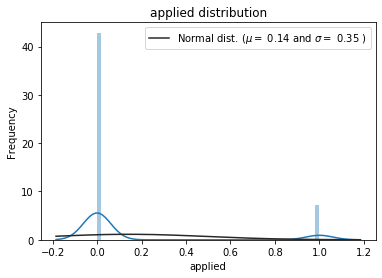

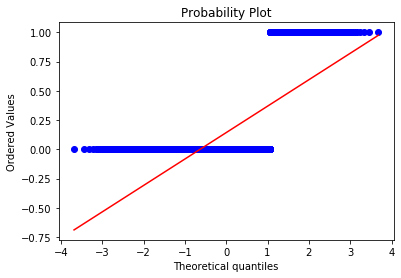

In [17]:
sns.distplot(train['applied'],fit=norm)
(mu, sigma) = norm.fit(train['applied'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('applied distribution')

fig = plt.figure()
res = stats.probplot(train['applied'],plot=plt)
plt.show()

In [19]:
# Class count
count_class_0, count_class_1 = train.applied.value_counts()

# Divide by class
df_class_0 = train[train['applied'] == 0]
df_class_1 = train[train['applied'] == 1]

print(len(df_class_0),len(df_class_1))

5143 857


Random under-sampling:
1    857
0    857
Name: applied, dtype: int64


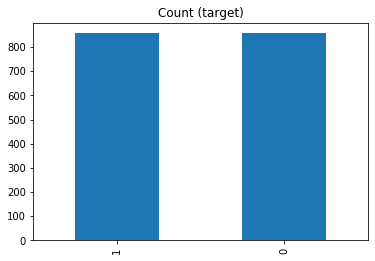

In [20]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.applied.value_counts())

df_test_under.applied.value_counts().plot(kind='bar', title='Count (target)');

# Feature들의  정규화 과정  
피쳐들이 한쪽으로 치우쳐저 있는것을 skew하다고 하는데 분포가 정규분포를 만들수록 
더 탄탄한 모델을 만들수있다 그래서 Normalize하는 과정을 거처준다. 
회귀 모델을 사용해야할때 정규화는 더욱 중요하다.  

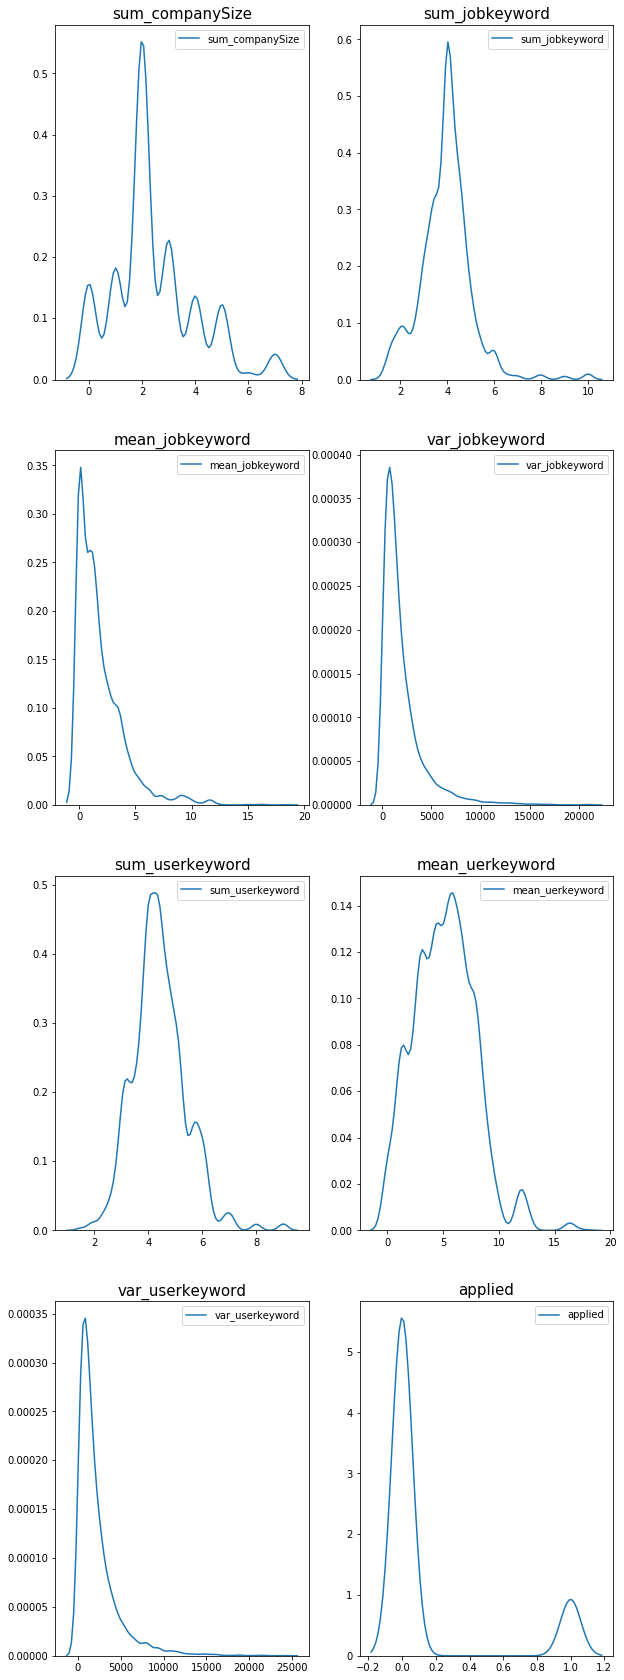

In [21]:
fig, ax = plt.subplots(4, 2, figsize=(10, 30))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = temp.columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(temp[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 8 :
            break

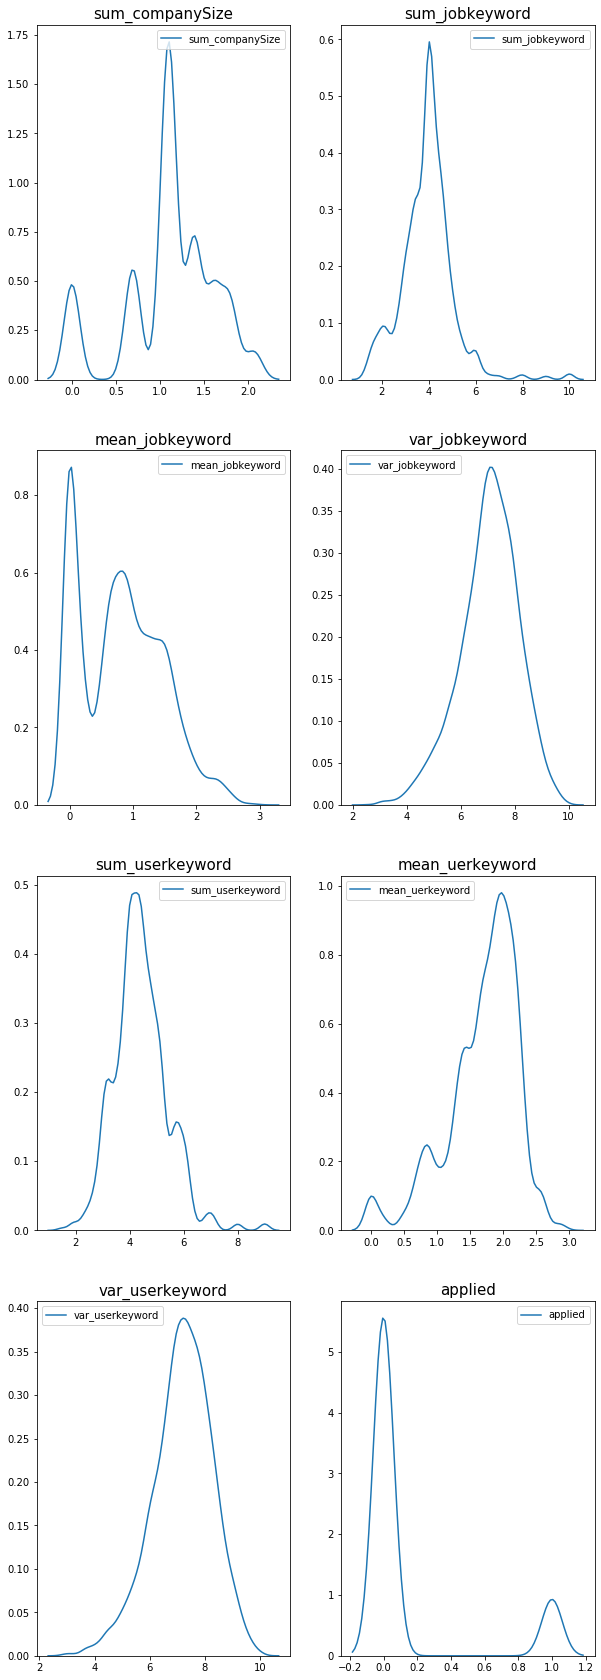

In [22]:
skew_columns = ['mean_jobkeyword', 'mean_uerkeyword', 'var_userkeyword', 'sum_companySize','var_jobkeyword']

for c in skew_columns:
    temp[c] = np.log1p(temp[c].values)
    
    
fig, ax = plt.subplots(4, 2, figsize=(10, 30))

# id 변수는 제외하고 분포를 확인합니다.
count = 0
columns = temp.columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(temp[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 8 :
            break

# feature와 target값의 관계 그래프 

In [23]:
temp = train.drop(['userID','jobID','companyID','var_companySize'],axis=1)

def plot_show(hue,ele):
   facet = sns.FacetGrid(temp,hue=hue,aspect=4)
   facet.map(sns.kdeplot,ele,shade=True)
   facet.set(xlim=(0,train[ele].max()))
   facet.add_legend()
   plt.show()

col-> sum_companySize


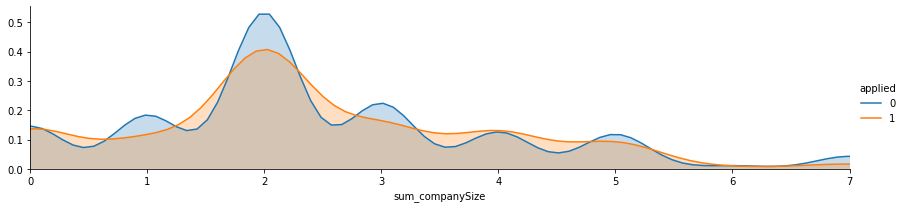

col-> sum_jobkeyword


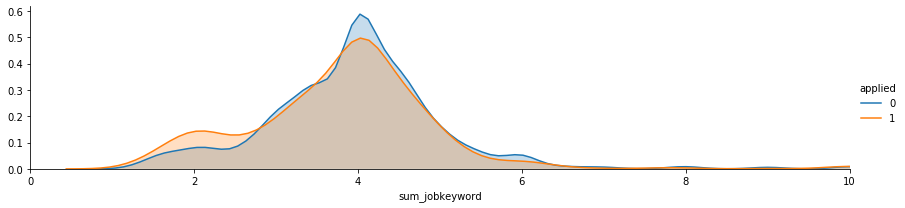

col-> mean_jobkeyword


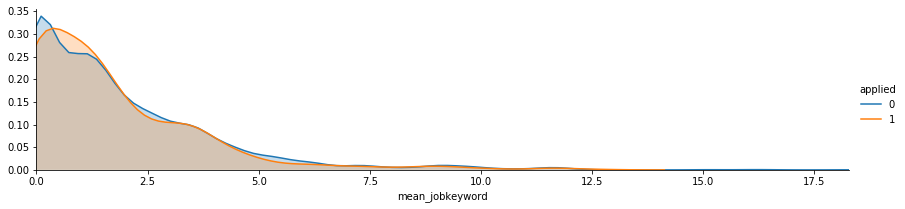

col-> var_jobkeyword


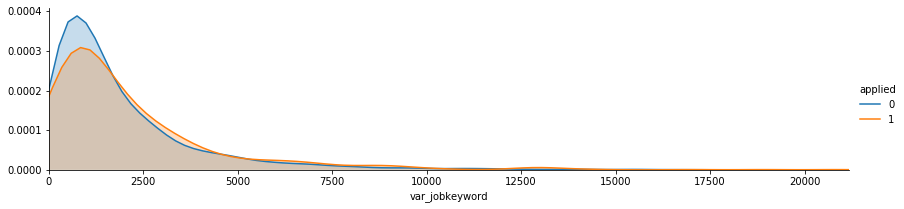

col-> sum_userkeyword


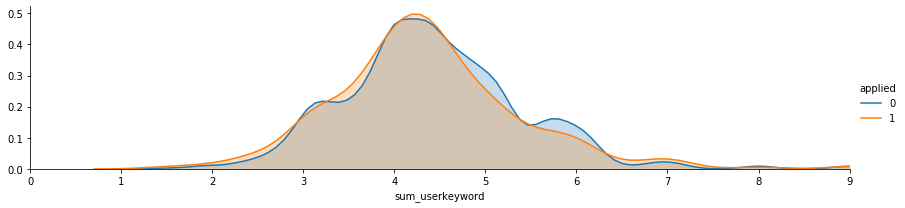

col-> mean_uerkeyword


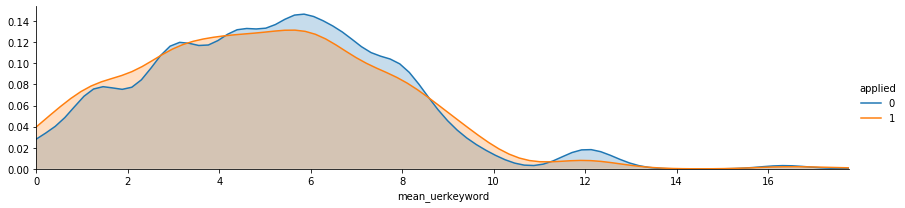

col-> var_userkeyword


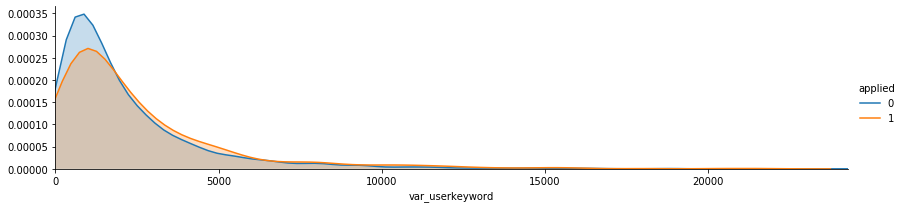

col-> interest


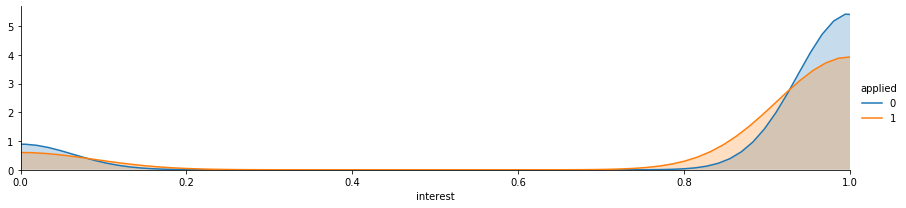

In [24]:
for i in temp.columns:
    if i != 'applied':
        print('col->',i)
        plot_show("applied",i)

#  모델 Train  
모델은 RandomForest, Xgboost, Adaboost 값을 ensemble했다

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek('auto')
X, y = smt.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2, random_state=100)
watchlist=[(X_train,y_train),(X_test,y_test)]

kfold = 8
skf = StratifiedKFold(n_splits=kfold, random_state=42)

%%time
rf = RandomForestClassifier()
rf.fit(X, y)
rf.score(X_test, y_test)

from xgboost import XGBClassifier
xgb = XGBClassifier()
#xgb.fit(X_train, y_train)
xgb.fit(X, y)
xgb_predict = xgb.predict(test)
print(xgb.score(X_test,y_test))


from xgboost import XGBClassifier
xgb = XGBClassifier()
#xgb.fit(X_train, y_train)
xgb.fit(X, y)
xgb_predict = xgb.predict(test)
print(xgb.score(X_test,y_test))


prediction = [xgb_predict,rf_predict,gsGBC_predict,adb_predict,rgc_predict,adbGRD_predict]
y_pred = np.mean(prediction, axis=0)


sub.to_csv("./sub/submission_recommend.csv",header= True, index=False)
temp = pd.read_csv('./sub/submission_recommend.csv')
temp.applied = temp.applied.apply(lambda x: int(x))
temp.to_csv("./sub/submission_recommend.csv",header= True, index=False)
temp = pd.read_csv('./sub/submission_recommend.csv')

# 모델 성능개선을 위한 노력   
1) 일단 var,mean,variance값만으로는 정확도를 올리기는 쉽지않았다. 그래서 새로운 feature를 만들어 주려고 했지만 대부분 성공하지 못했다. 
interest feature는 지원자의 keyword랑 회사의 keyword가 얼마나 관계가 있는지를 나타내주려고했다. 

2) keyword값을 임의로 나누어 주었다. 일단 모르는 keyword도있었지만 어느정도 수작업으로 진행했다.  
3) target값의 inbalance부분을 resampling을 통해 개선해 주었다.  
4) feature들이 너무 skew하다면 normalizing을 통해서 normal하게 바꾸어  주려고 했다. 
5) 많은 모델을 쓰기보다는 3가지정도를 ensemble하는 용도로만 사용하였다. 

# 아쉬웠던점  또는 개선 아이디어
1) keyword값을 임의로 시간이 없어서 저혼자 나누어 줬던 부분이 아쉬웠다 시간이 있었다면 관련 다큐먼트들을 모아서 word2vec같은 모델을 만들면 좀더 similarity같은 feature들을 생성할수있지 않을까 생각이 들었습니다. 
2) normalizing이나 resampling같은경우 눈에 띄는 성능 향상은 없었다. 그래서 좀더 이런 이유를 알고 진행했으면 좋았다고 생각했습니다.  
3) 새로운 피쳐를 만들었을때도 이것을 test해볼수있는 방법이나 이런것들을 좀더 정확히 알고 사용하고싶습니다.  
4) 또한 모델에 대해 좀더 깊은 지식이있었다면 좋았을거같습니다.  
5) clustering algorithm을 통해서 KNN 8값으로 값을 clustering해준다음 결과 값을 새로운 피쳐로 추가해줘봤지만 그다지 성과는 없었습니다. 
6) inbalance된 target값에 normalizing을 적용했지만 값이 떨어졌지만 아직 이유를 확인하지 못했습니다.
7) 마지막 날에 feature normalizing과 target값 resampling을 해주었지만 결과 값이 86%에서 80%정도 까지 떨어졌는데 이것이 훈련이 더 잘되서 그런건지 아니면 값이 떨어진건지는 알수가 없었습니다. 이런부분은 추후에 다른 대회를 통하거나 혼자서 실험을좀 해봐야겠다는 생각이 들었습니다. 실험은 제가 이 테스트환경하고 똑같이 잡아놓고 비교해보면 알수있을거라고 생각했습니다. 

# 마무리   
아이디어들이 시간이 많이걸리는 작업이라(keyword분류 similarity값 추가, word2vec생성 등등) 적용해보지 못한점들이 아쉬웠으며  
normalizing이나 resampling을 적용했을때 성능이 떨어지지 못한부분을 이해하지 못한것들이 아쉬웠습니다.   
좋은 분들과 이런것들을 discuss해가면서 일을 해보고 싶습니다. 짮은 시간 즐거웠습니다.2019년 마무리 잘하시길 바랍니다.   
비젼문제와 추천문제 둘다 즐거웠습니다. 